# Generate Input Data

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import seaborn as sns

In [33]:
width = 35
height = 35
n_examples = 100
max_sigma = 3.0
max_val = 1
rng = np.random.default_rng()

In [34]:
def heatmap(raw_data):
  magnitude = np.linalg.norm(raw_data, axis=2)
  sns.heatmap(magnitude)
  plt.show()
  return

In [35]:
def quiver(raw_data):
  X, Y = np.meshgrid(np.linspace(0,1,width), np.linspace(0,1,height))
  U = raw_data[:,:,0]
  V = raw_data[:,:,1]
  magnitude = np.linalg.norm(raw_data, axis=2)
  plt.quiver(X,Y, U, V, magnitude)
  plt.show()

In [36]:
def generate_frame(sigma=2):
  data = rng.random((width, height, 2))
  data = (data * max_val * 2) - max_val
  blur = np.random.uniform(low=0.5, high=max_sigma)
  data = gaussian_filter(data, sigma=(blur, blur, 0))
  return data

In [37]:
def generate_inputs(n):
  return np.array([generate_frame() for _ in range(n)])

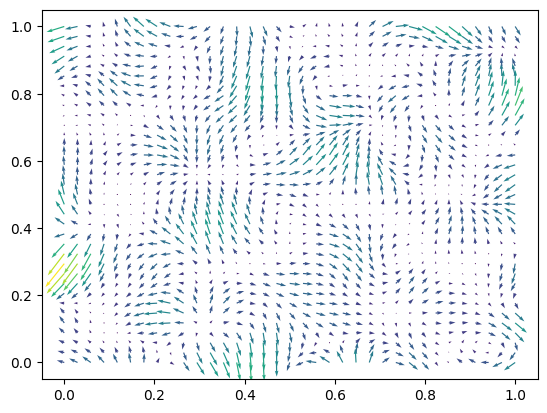

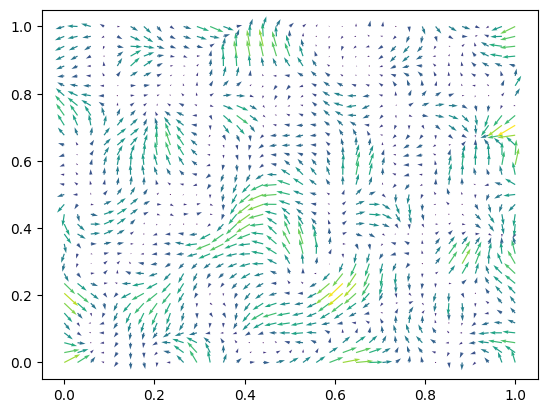

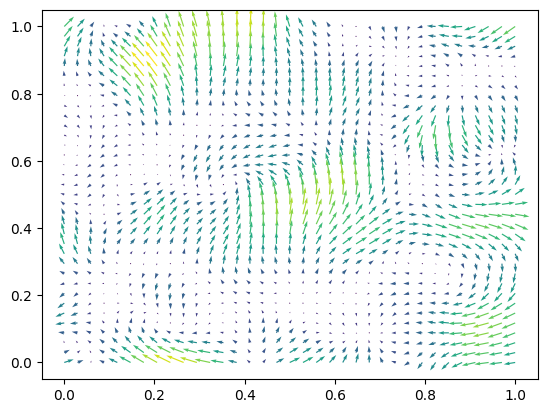

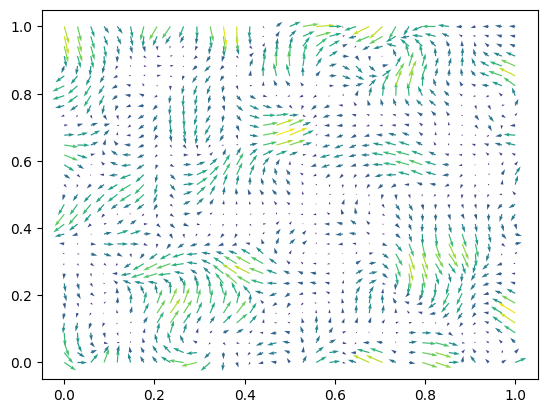

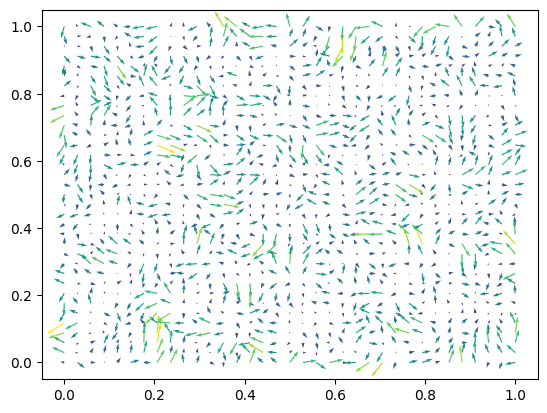

In [38]:
inputs = generate_inputs(n_examples)
for i in range(5):
  frame = inputs[i]
  quiver(frame)

# Generate Labels

In [39]:
def get_kinetic_engergy(frame):
  kinetic_engergy = np.sum((0.5 * np.sum(np.square(frame), axis=2)))
  return kinetic_engergy

10.046452293383002


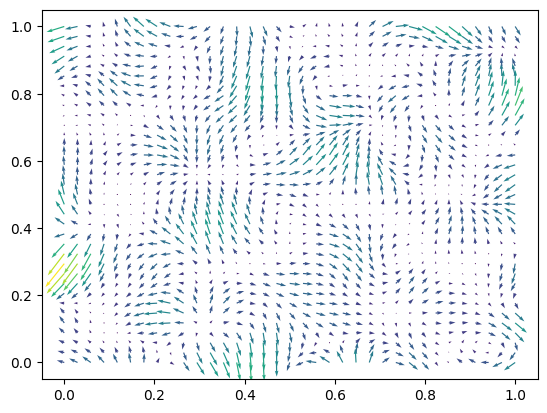

20.222129263192578


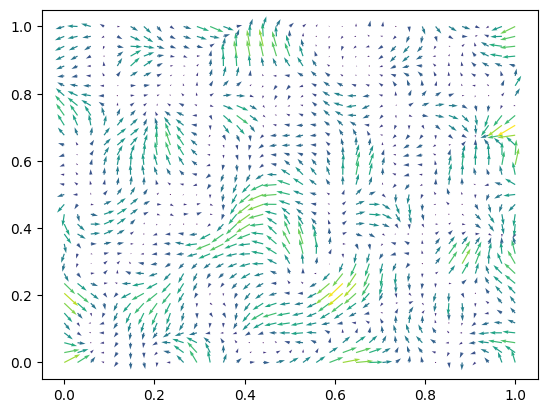

11.532883587688486


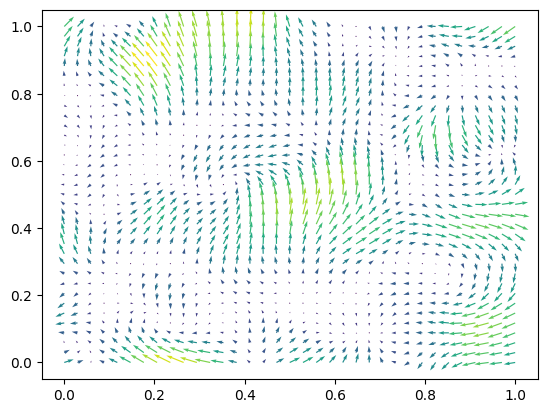

18.42582960373013


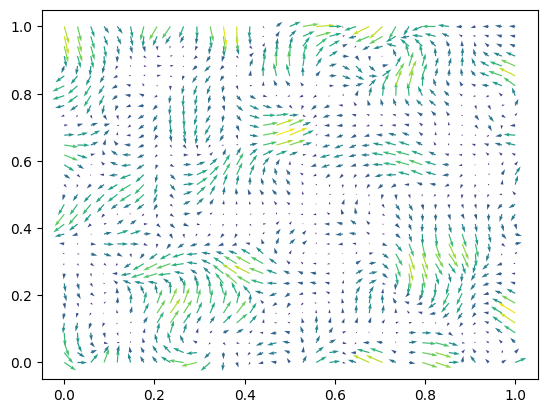

61.28779503640945


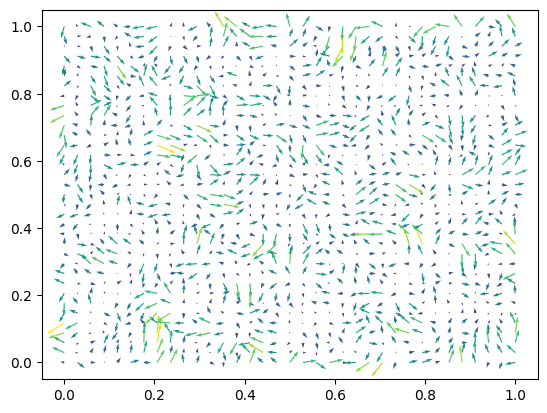

In [40]:
for i in range(5):
  print(get_kinetic_engergy(inputs[i]))
  quiver(inputs[i])

In [ ]:
outputs = np.array([get_kinetic_engergy(input) for input in inputs])

# Generate graph representation

In [41]:
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
import networkx as nx
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')

Using device cpu


In [42]:
def coords_to_id(x_pos, y_pos):
    return width * x_pos + y_pos
def id_to_coords(id):
    return (id // width, id - width * (id // width))

In [43]:
n_examples = 1000
inputs = generate_inputs(n_examples)

Construct an edge list for a regular 2d grid representation of the fluid

In [44]:
edge_list = []
for x_pos in range(inputs.shape[1]):
    for y_pos in range(inputs.shape[2]):
        if(x_pos != inputs.shape[1]-1):
            edge_list.append([coords_to_id(x_pos, y_pos), coords_to_id(x_pos+1, y_pos)])
        if(y_pos != inputs.shape[2]-1):
            edge_list.append([coords_to_id(x_pos, y_pos), coords_to_id(x_pos, y_pos+1)])
        if((x_pos != inputs.shape[1]-1) and (y_pos != inputs.shape[2]-1)):
            edge_list.append([coords_to_id(x_pos, y_pos), coords_to_id(x_pos+1, y_pos+1)])

edge_list = torch.tensor(edge_list).to(device).T

Construct dataloader object, now 100% ready for any pytorch geometric workflow

In [45]:
x = torch.tensor(inputs).view(inputs.shape[0], -1, inputs.shape[-1]).to(device)
data_list = []
for i in range(100):
    data_list.append(pyg.data.Data(x=x[i], edge_index=edge_list, y=get_kinetic_engergy(inputs[i])))
loader = DataLoader(data_list, batch_size=32)

Sanity check: convert torch_geoemtric data object into NetworkX graph and visualize

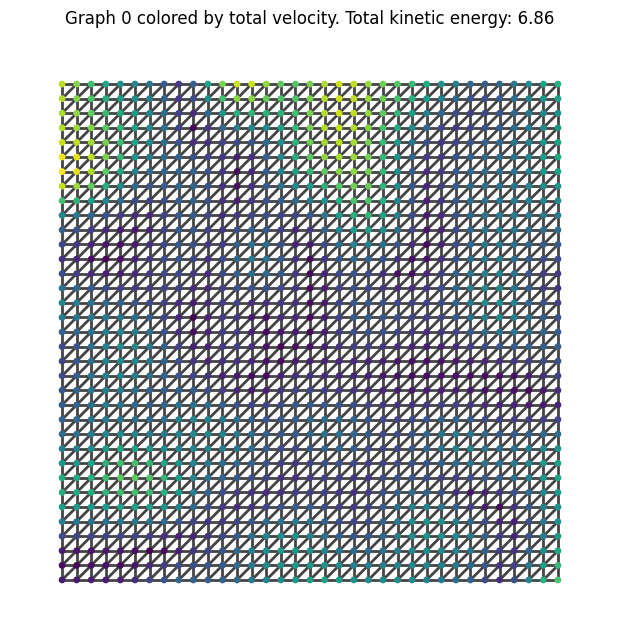

In [46]:
i=0
G = pyg.utils.to_networkx(data_list[i], to_undirected=True)
pos = {n:id_to_coords(n) for n in G.nodes}

plt.figure(figsize=(6, 6))
nx.draw(
    G, pos,
    node_size=15,
    node_color=[np.linalg.norm(a) for a in data_list[0].x.detach().cpu().numpy()],
    edge_color="#444444",
    width=2,
    font_size=8
)
plt.title(f'Graph {i} colored by total velocity. Total kinetic energy: {np.round(data_list[i].y, 2)}')
plt.show()

### Representation as cubical complex (topomodelx)
I still have to figure out how this works :/

In [47]:
import toponetx as tnx
import topomodelx as tmx

In [48]:
G.edges

EdgeView([(0, 35), (0, 1), (0, 36), (1, 36), (1, 2), (1, 37), (2, 37), (2, 3), (2, 38), (3, 38), (3, 4), (3, 39), (4, 39), (4, 5), (4, 40), (5, 40), (5, 6), (5, 41), (6, 41), (6, 7), (6, 42), (7, 42), (7, 8), (7, 43), (8, 43), (8, 9), (8, 44), (9, 44), (9, 10), (9, 45), (10, 45), (10, 11), (10, 46), (11, 46), (11, 12), (11, 47), (12, 47), (12, 13), (12, 48), (13, 48), (13, 14), (13, 49), (14, 49), (14, 15), (14, 50), (15, 50), (15, 16), (15, 51), (16, 51), (16, 17), (16, 52), (17, 52), (17, 18), (17, 53), (18, 53), (18, 19), (18, 54), (19, 54), (19, 20), (19, 55), (20, 55), (20, 21), (20, 56), (21, 56), (21, 22), (21, 57), (22, 57), (22, 23), (22, 58), (23, 58), (23, 24), (23, 59), (24, 59), (24, 25), (24, 60), (25, 60), (25, 26), (25, 61), (26, 61), (26, 27), (26, 62), (27, 62), (27, 28), (27, 63), (28, 63), (28, 29), (28, 64), (29, 64), (29, 30), (29, 65), (30, 65), (30, 31), (30, 66), (31, 66), (31, 32), (31, 67), (32, 67), (32, 33), (32, 68), (33, 68), (33, 34), (33, 69), (34, 69),

In [49]:
cubical_complex = tnx.transform.graph_to_clique_complex(G)

In [50]:
cubical_complex.complex

{}

# Questions
- Which type of energy (instantanious total kinetic energy)?
- How much smoothing?
- What are nodes and edges (evenly distributed? con)
